# Graph Analytics applied to Eurovision Song Contest - A Tutorial

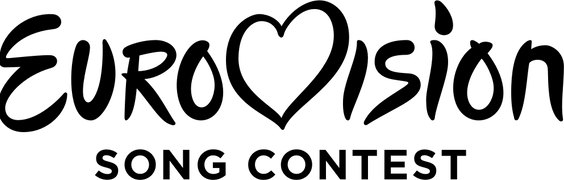

# Table of contents
1. [Introduction](#introduction)
2. [Study overview](#overview)
3. [Loading data](#loadingData)
4. [Data Exploration](#dataExploration)
5. [Triads](#Triads)
6. [Exploring Spectral properties](#spectral)
7. [Main Eurovision graph constrution](#MainGraph)
8. [Experimental part of the analysis](#Experimental)


# Introduction <a name="introduction"></a>

## Eurovision song contest

Eurovision Song Contest is a contest organized by the European Broadcast Union (EBU). Their vision is to united european countries after the WWII.

The contestant key points are:
* The event happens annualy since 1956.
* Every participant broadcaster should indicate an artist or band to represent the country every eary
* The voting system is divided in Jury Votes and, more recently, the Televoting:
 * Jury is a group of experts that usualy belong to the music industry.
 * Televoting is the vote given by the public using SMS, phone or eurovision app.
 * A country (jury or public) cannot vote himself.
 
 
* Every country votes in 12 of the 41 participants. The top choice receice 12 points and the last one receive 1 vote.
 * Only the top 3 is annnouced on the finals.
 
 For more information, please check [eurovision.tv](!https://eurovision.tv/about/how-it-works)

## Why using graph analytics on this dataset

Despite of its main effort to unite Europe throught the music, many situation shows a very delicate politicial, social and economic problems.  Follow a list of reasons to study the relationship of european countries in this music festival:

* Political:
 * Germany was reunited.
 * Yuguslavia was splitted in many countries.
 * There were many wars on the balcans (Crimea, Kosovo, etc).
 * Greece, Spain and Portugal were affect by the adoption of Euro and felt into a economic crisis.
 * Imigrations have changed. Ex. Polish people living in Germany can vote on Poland as they were germans.
 * Israel has strong ties with many european countries.
  * Many arab countries are also part of EBU but choosen not to participate due to Israel.
  * Iceland protested in Tel Aviv 2019 edition (https://www.timesofisrael.com/iceland-fined-for-eurovision-pro-palestinian-protest-at-tel-aviv-final/)
 * Russia and Ukraine has many territorial disputes:
  * Jamala's 2017 was seeing as protest over Crimea.
 * Russia still hold strong influence over the former USSR countries.
 * Turkey/Azerbaijan had and have strong and blood conflits with Arminia (Arminian Genocide).
 
* Cultural:
 * Many clusters emerge naturally due to language family:
  * The romance languages in Iberic peninsula.
  * The slavic languages in the balcan + russia.
  * The germanic languages in the north.
  * The greek (pro-greek languages) in Greee, Cyprus and Armenia (debatable)
 * Religions:  Agnostics, muslins, cristhians catholic, cristhians orthodox, etc.
 * LGBT support:
  * Turkey says will participated on eurovision due to Conchita victory on 2014 edition.

* Some countries allways give their 12 point the their best friends (ex. Greece <--> Cyprus).

These points were study in some cientific articles. 

# 2. Study overview <a name="overview"></a>


## Questions we want to answer

* Is there any bias on voting?
* What are the most influencial country in the competition ?
* Are the countries organized in communites ?
* Are the countries organized by cultural affinity, like languages and so on ?
* Is the geographical distance important?



## Libraries

In [1]:
#numerical/system libs

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.max_rows = 999
pd.options.display.max_columns = 200
import re
import random
import json
import functools


#visualization libs
%matplotlib inline
#%config InlineBackend.figure_format ='retina'

import pylab as plt
import seaborn as sns
sns.set_style('whitegrid')
from ipywidgets.widgets import HTML
from tqdm import tqdm


#graph and network libs
import networkx as nx
import community as louvain


#machine learning libs
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn import decomposition, manifold

from gensim.models import Word2Vec

In [2]:
# many graph algorithms depends on random inicialization
def  setRandom():
    random.seed(42)
    np.random.seed(42)

setRandom()

# 3. Loading Data <a name='loadingData'><a>

This project is mainly focused on graph / networks and social networks analysis.  So I did some basic explorations about maps / geo information. Below it is manually configured the positions for each country capital.

In [3]:
#Manual configuration of the capital of eurovision affiliated countries

latLongFixed = pd.DataFrame.from_records(
[{'countryfrom': 'Albania', 'Capital': 'Tirane', 'Latitude': 41.3310413, 'Longitude': 19.7828036},
 {'countryfrom': 'Andorra', 'Capital': 'Andorra la Vella', 'Latitude': 42.5051006, 'Longitude': 1.5116108},
 {'countryfrom': 'Armenia', 'Capital': 'Yerevan', 'Latitude': 40.1535684, 'Longitude': 44.3484804},
 #{'countryfrom': 'Australia', 'Capital': 'Canberra', 'Latitude': -35.15, 'Longitude': 149.08},
  {'countryfrom': 'Australia', 'Capital': 'Canberra', 'Latitude': 36, 'Longitude': -19}, #fake location to make the graph looks pretier than the real location
 {'countryfrom': 'Austria',   'Capital': 'Vienna', 'Latitude': 48.2208286, 'Longitude': 16.2399746},
 {'countryfrom': 'Azerbaijan', 'Capital': 'Baku', 'Latitude': 40.3947695, 'Longitude': 49.714873},
 {'countryfrom': 'Belarus', 'Capital': 'Minsk', 'Latitude': 53.8847608, 'Longitude': 27.4532841},
 {'countryfrom': 'Belgium', 'Capital': 'Brussels', 'Latitude': 50.8550625, 'Longitude': 4.3053498},
 {'countryfrom': 'Bosnia', 'Capital': 'Sarajevo', 'Latitude': 43.8938852, 'Longitude': 18.2429054},
 {'countryfrom': 'Bulgaria', 'Capital': 'Sofia', 'Latitude': 42.6955992, 'Longitude': 23.1838604},
 {'countryfrom': 'Croatia', 'Capital': 'Zagreb', 'Latitude': 45.8403496, 'Longitude': 15.8242458},
 {'countryfrom': 'Cyprus', 'Capital': 'Nicosia', 'Latitude': 35.1923727, 'Longitude': 33.3273614},
 {'countryfrom': 'Czech Republic', 'Capital': 'Prague', 'Latitude': 50.0598058, 'Longitude': 14.3255389},
 {'countryfrom': 'Denmark', 'Capital': 'Copenhagen', 'Latitude': 55.6713442, 'Longitude': 12.523784},
 {'countryfrom': 'Estonia', 'Capital': 'Tallinn', 'Latitude': 59.4717421, 'Longitude': 24.4580607},
 {'countryfrom': 'Finland', 'Capital': 'Helsinki', 'Latitude': 60.11021, 'Longitude': 24.7385001},
 {'countryfrom': 'France', 'Capital': 'Paris', 'Latitude': 48.8589507, 'Longitude': 2.2770197},
 {'countryfrom': 'Georgia', 'Capital': "T'bilisi", 'Latitude': 41.7326304, 'Longitude': 44.6987664},
 {'countryfrom': 'Germany', 'Capital': 'Berlin', 'Latitude': 52.5069312, 'Longitude': 13.1445453},
 {'countryfrom': 'Greece', 'Capital': 'Athens', 'Latitude': 37.9909517, 'Longitude': 23.6682987},
 {'countryfrom': 'Hungary', 'Capital': 'Budapest', 'Latitude': 47.4813602, 'Longitude': 19.9902175},
 {'countryfrom': 'Iceland', 'Capital': 'Reykjavik', 'Latitude': 64.1335484, 'Longitude': -21.9224819},
 {'countryfrom': 'Ireland', 'Capital': 'Dublin', 'Latitude': 53.3244431, 'Longitude': -6.3857885},
 {'countryfrom': 'Israel', 'Capital': 'Jerusalem', 'Latitude': 31.7965337, 'Longitude': 35.0352712},
 {'countryfrom': 'Italy', 'Capital': 'Rome', 'Latitude': 41.9102415, 'Longitude': 12.3959115},
 {'countryfrom': 'Latvia', 'Capital': 'Riga', 'Latitude': 56.9715357, 'Longitude': 24.8489796},
 {'countryfrom': 'Lithuania', 'Capital': 'Vilnius', 'Latitude': 54.7007582, 'Longitude': 25.972849},
 {'countryfrom': 'Luxembourg', 'Capital': 'Luxembourg', 'Latitude': 49.6076951, 'Longitude': 6.0658298},
 {'countryfrom': 'Macedonia', 'Capital': 'Skopje', 'Latitude': 41.9991965, 'Longitude': 21.3548497},
 {'countryfrom': 'Malta',     'Capital': 'Valletta', 'Latitude': 35.8984976, 'Longitude': 14.5044102},
 {'countryfrom': 'Moldova', 'Capital': 'Chisinau', 'Latitude': 47.0000178, 'Longitude': 28.718091},
 {'countryfrom': 'Monaco',  'Capital': 'Monte Carlo', 'Latitude': 43.7410682, 'Longitude': 7.4172157},
 
 {'countryfrom': 'Montenegro', 'Capital': 'Montenegro', 'Latitude': 42.708679, 'Longitude': 19.37439},
 {'countryfrom': 'Morocco', 'Capital': 'Rabbat', 'Latitude': 31.791702, 'Longitude': -7.09262},
 {'countryfrom': 'Netherlands', 'Capital': 'Amsterdam', 'Latitude': 52.3547925, 'Longitude': 4.7638758},
 {'countryfrom': 'Norway',   'Capital': 'Oslo', 'Latitude': 59.8937803, 'Longitude': 10.6446921},
 {'countryfrom': 'Poland',   'Capital': 'Warsaw', 'Latitude': 52.2328546, 'Longitude': 20.9207684},
 {'countryfrom': 'Portugal', 'Capital': 'Lisbon', 'Latitude': 38.7436056, 'Longitude': -9.2304149},
 {'countryfrom': 'Romania',  'Capital': 'Bucuresti', 'Latitude': 44.4377397, 'Longitude': 25.9542107},
 {'countryfrom': 'Russia',   'Capital': 'Moskva', 'Latitude': 55.5807418, 'Longitude': 37.8237562},
 {'countryfrom': 'San Marino', 'Capital': 'San Marino', 'Latitude': 43.9428565, 'Longitude': 12.3898818},
 {'countryfrom': 'Serbia', 'Capital': 'Belgrade', 'Latitude': 44.8151593, 'Longitude': 20.2821702},
 {'countryfrom': 'Slovakia', 'Capital': 'Bratislava', 'Latitude': 48.1356948, 'Longitude': 16.9754907,},
 {'countryfrom': 'Slovenia', 'Capital': 'Ljubljana', 'Latitude': 46.0660959, 'Longitude': 14.4618877},
 {'countryfrom': 'Spain', 'Capital': 'Madrid', 'Latitude': 40.4378693, 'Longitude': -3.8199641,},
 {'countryfrom': 'Sweden', 'Capital': 'Stockholm', 'Latitude': 59.3260664, 'Longitude': 17.841628},
 {'countryfrom': 'Switzerland', 'Capital': 'Bern', 'Latitude': 46.9546485, 'Longitude': 7.3246587},
 {'countryfrom': 'Turkey', 'Capital': 'Ankara', 'Latitude': 39.9032919, 'Longitude': 32.6223372},
 {'countryfrom': 'Ukraine', 'Capital': 'Kiev', 'Latitude': 50.4016974, 'Longitude': 30.251825},
 {'countryfrom': 'United Kingdom', 'Capital': 'London', 'Latitude': 51.5285578, 'Longitude': -0.05}]
)

In [4]:
#countries  participants of eurovision and their neighbours. 
countriesCodes =['AE','AU','SA','SY','BE', 'EL','GR', 'LT', 'PT', 'BG', 'ES', 'LU', 'RO','GB','KZ','TM',
                 'CZ', 'FR', 'HU', 'SI', 'DK', 'HR', 'MT', 'SK', 'DE', 'IT', 'NL', 'FI','IQ',
                 'EE', 'CY', 'AT', 'SE', 'IE', 'LV', 'PL', 'UK', 'IS', 'NO', 'LI', 'CH','KW','OM',
                 'ME', 'MK', 'AL', 'RS', 'TR', 'BA', 'XK', 'AM', 'BY', 'GE', 'AZ', 'MD', 'UA', 'IR',
                 'IL', 'DZ', 'LB', 'SY', 'EG', 'LY', 'TN', 'IL', 'MA', 'RU', 'JO', 'PS','LB','PS','YE','JO','MT']

countriesBorders = json.loads(open('../input/countries-borders/countries.geojson').read())

In [5]:
#moving australia shape from south pacific to north atlantic for visualization purpose
ausCenter = pd.DataFrame(latLongFixed)[['Longitude','Latitude']].min().values+5
for n in countriesBorders['features']:
    if n['properties']['name']=='Australia':
        geometry = n['geometry'];
        if geometry['type'] == 'MultiPolygon':
            for c in geometry['coordinates']:
                for i in range(len(c)):
                    c[i] = ((np.array(c[i]) + np.array([-150,35]))/2+ausCenter).tolist()

In [6]:
# TODO: in a future relase this code will be replace by folium or other library
from matplotlib.patches import Polygon, Rectangle
def plotCountry(x, fill=False, fill_color='#fff'):
    coord = x['coordinates'];
    def draw(p):
        if len(p) < 2:
            return;
        p = np.array(p);
        plt.gca().plot(p[:,0],p[:,1],c='#cccccc', zorder=1)
        plt.gca().add_patch(Polygon(p,color=fill_color, zorder=1))
            
    if x['type'] == 'MultiPolygon':
        for p in coord:
            draw(p[0])
            
    if x['type'] == 'Polygon':
        draw(coord[0])

In [7]:
# Eurovision dataset with data from 1975 to 2019 

df = pd.read_excel('/kaggle/input/eurovision-song-contest-scores-19752019/eurovision_song_contest_1975_2019.xlsx')
df.columns = ['year','final','edition','votetype','countryfrom','countryto','points','duplicate'];

# Data cleaning

* Removing empty edges (point ==0)
* Removing edges marked as duplicated
* Renaming some countries (Macedonia).  Please don't go into political discussions about that.
* Broadcasting the results of Yugoslavia to its former countries.
* Removing countries with few participations

In [8]:
def basicClean(df, minYears = 5, last_participation=8):
    df2 = df.copy().query('points > 0')
    
    #Removing duplicates
    df2['duplicate'] = df2['duplicate'].apply(lambda x: True if x == 'x' or x==True else False)
    df2 = df2.query('duplicate == False').drop(columns=['duplicate'])

    
    #Stantardazing countries names.
    def applyRename(x):
        renamings ={
            'North Macedonia':'Macedonia',
            'F.Y.R. Macedonia':'Macedonia',
            'The Netherands': 'Netherlands',
            'The Netherlands':'Netherlands',
            'Bosnia & Herzegovina':'Bosnia',
        }
        return renamings[x] if x in renamings else x

    df2['countryfrom'] = df2['countryfrom'].apply(applyRename)
    df2['countryto']   = df2['countryto'].apply(applyRename)
    
    

    #replicating  Yugoslavia's results to countries that part of it.
    division = {
        'Yugoslavia':['Macedonia','Serbia','Montenegro','Slovenia','Bosnia','Croatia'],
        'Serbia & Montenegro':['Serbia','Montenegro'],
    }
    
    df2['countryfrom'] = df2['countryfrom'].apply(lambda x:division[x] if x in division else x)
    df2['countryto']   = df2['countryto'].apply(lambda x:division[x] if x in division else x)
    df2 = df2.explode('countryfrom').explode('countryto')
    
    
    
    # removing countries with less then 5 participations and not active in the last 5 years
    toKeep = df2.groupby('countryfrom').apply(lambda x:pd.Series({
        'years':x['year'].nunique(),
        'last_participation':df2['year'].max() - x['year'].max(),
    })).query(f'years >= {minYears} and last_participation <= {last_participation}').reset_index()['countryfrom'];
    
    display(HTML("<p>ignored countries: %s</p>" %', '.join(df2[df2['countryfrom'].isin(toKeep)==False]['countryfrom'].unique())))

    df2 = df2[df2['countryfrom'].isin(toKeep)]
    df2 = df2[df2['countryto'].isin(toKeep)]
    
    
    #keep only the points received at the highest stage (finals/semifinals)
    df2['finalcode']=df2.final.map({'f':1,'sf':2,'sf1':2,'sf2':2})
    temp1 = df2.groupby(['countryto','year']).agg({'finalcode':'min'});
    df2 = pd.merge(df2,temp1, on=['countryto','year','finalcode'], how='inner')
    
    assert len(df2.groupby(['countryfrom','countryto','year']).agg({'final':'nunique'}).query('final >1')) == 0
    
    df2.drop(columns=['finalcode','edition'], inplace=True)
    
    return df2.reindex()

df2 = basicClean(df);
display(HTML(str(len(df2))))
df2.sample(5)

HTML(value='<p>ignored countries: Luxembourg, Monaco, Morocco, Andorra</p>')

HTML(value='17199')

year final votetype countryfrom    countryto  points
11124  2012     f        J    Slovakia   Azerbaijan       6
14765  2017     f        J   Lithuania  Netherlands       2
3053   1988     f        J     Denmark      Croatia      12
6504   2001     f        J      Greece       Russia       5
3501   1990     f        J       Italy      Denmark       7

# 4. Data exploration <a name='dataExploration'></a>


The purpose of this section is to understand how the data is organized, the presence of outliers, etc. And, provide some intuition for the following analysis.

In [9]:
df2\
    .groupby(['countryto'])\
    .apply(lambda x:pd.Series({
        'nyear':x['year'].nunique(),
        'min_year':x['year'].min(),
        'max_year':x['year'].max(),
        'presence':int(100*x['year'].nunique()/(x['year'].max()-x['year'].min()+1))
    }))\
    .sort_values('nyear',ascending=False)\
    .style.bar(subset='nyear', color=['royalblue'])
    #.plot(kind='bar',figsize=(15,2), title='Participation by country');

* nyear - number of editions
* min_year - first edition
* max_year - last edition
* presence - %participation since first edition

In [10]:
#The Winner
df2.query('final =="f"')\
    .groupby(['countryto','year']).agg({'points':'sum'}).reset_index()\
    .groupby('year').apply(lambda x:x.sort_values('points').tail(1)).reset_index(drop=True)\
    .sort_values('year',ascending=False)\
    .head(12).T.style.set_caption("The Winners").hide_index()\
    #.bar(subset=['points'], color='#d65f5f')

In [11]:
def atTop(df,tops):
    #points received
    df= df.groupby(['countryto','year']).agg({'points':'sum'}).reset_index().groupby('year')
    
    #top1 (country with most of points)
    top = df.apply(lambda x:x.sort_values('points').tail(1)).reset_index(drop=True)\
        .groupby('countryto').agg({'year':'nunique'}).rename(columns={'year':'years_on_top'}).reset_index()
    
    #the other tops
    for t in tops:
        temp = df.apply(lambda x:x.sort_values('points').tail(t)).reset_index(drop=True)\
            .groupby('countryto').agg({'year':'nunique'})\
            .rename(columns={'year':f'years_on_top_{t}'}).reset_index()
        top = pd.merge(top,temp, on='countryto',how='outer')
        
    top = top.fillna(0);
    floatcols = top.columns[top.dtypes == 'float64']
    top[floatcols] = top[floatcols].astype(int)
        
    return top

Irleand is the country with the largest number of victories but this dataset doesn't containts the editions from 1956 to 1974. 

In [12]:
dfAtTop = atTop(df2.query('final =="f"'), tops=[3,5,7,10])
dfAtTop.sort_values(['years_on_top','years_on_top_3'], ascending=[False,False]).head(20)\
    .style.bar(subset=['years_on_top','years_on_top_3','years_on_top_5','years_on_top_7','years_on_top_10'],
               color='#cccccc')

Some countries seem to concentrate their votes on specific partners and other countries never votes on their neighbours.

In [13]:
def plotRankByCountry(countryFrom, minYear, crop = 30):
    temp = df2 \
        .query(f'year >= {minYear} and countryfrom=="{countryFrom}"')\
    
    
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,8))

    # top friends of Jury
    temp.pivot_table(index='countryto',columns='votetype',values='points',aggfunc='sum')\
        .fillna(0).sort_values('J', ascending=False).head(crop)\
        .plot(kind='bar',stacked=True,ax=axs[0,0], title=f'Total point by country after {minYear} from {countryFrom}');

    temp1 =  temp\
        .pivot_table(index='countryto',values='points',aggfunc='sum').fillna(0).sort_values('points', ascending=False);
    
    
    ########
    temp1.apply(lambda x:x/x.sum()).head(crop)\
        .plot(kind='bar',stacked=True,ax=axs[1,0], title=f'Total normalized point by country after {minYear} from {countryFrom}');

    
    ########  pay attention to number of countries that is necessary to reach pareto
    temp1.apply(lambda x:x/x.sum()).cumsum().head(crop)\
        .plot(stacked=True,ax=axs[1,0].twinx());
    axs[1,0].grid(False)

    
    
    temp1.apply(lambda x:(1-x/x.sum()).diff()).head(crop)\
        .plot(kind='bar',stacked=True,ax=axs[0,1], title=f'Diff of cummulative curve by country after {minYear} from {countryFrom}');

    def norm(x):
        x['points'] /= x['points'].sum()
        return x

    temp_sorted = temp.groupby('year').apply(norm).reset_index(drop=True)
    t =temp_sorted.groupby('countryto').sum().sort_values('points').index.values[::-1]
    t = t[0:crop]

    ax=sns.boxplot(data=temp_sorted[temp_sorted['countryto'].isin(t)], x='countryto', y='points', order=t,ax=axs[1,1]);
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
    ax.set_title('Boxplot of the normalized points by year sorted by sum')
    plt.tight_layout()

We clearly see that Iceland has given most of its high votes to its neighbours.

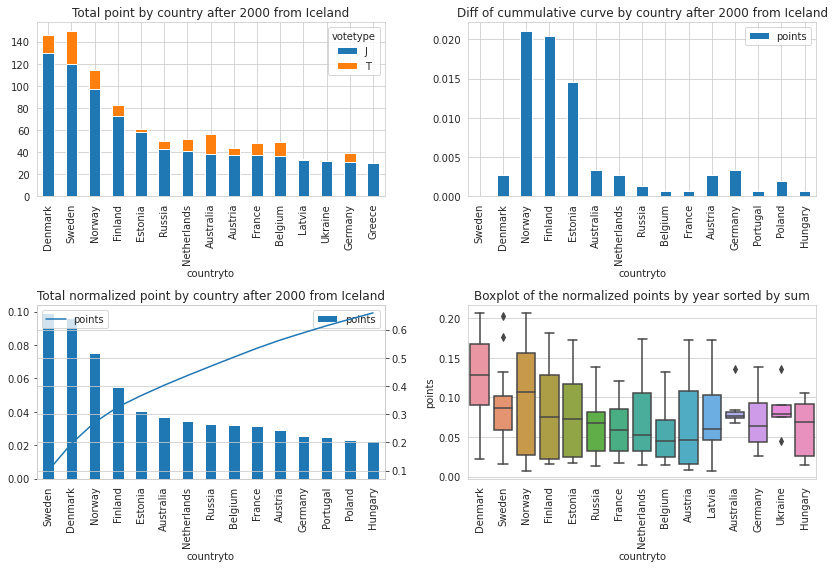

In [14]:
plotRankByCountry(countryFrom = 'Iceland',minYear = 2000, crop=15)

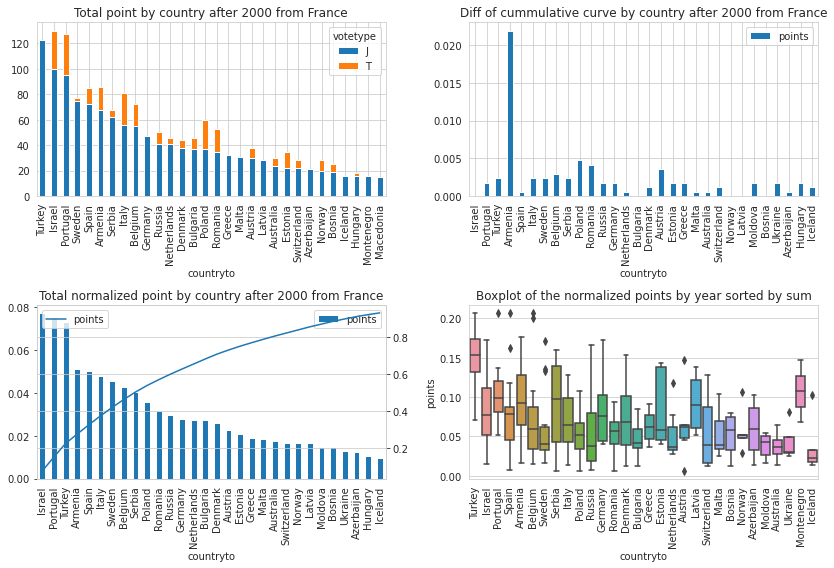

In [15]:
plotRankByCountry(countryFrom = 'France',minYear = 2000, crop=30)

The Jury can influence more the result than the public (Televote) and, in many cases, is clear the diference on their preference.

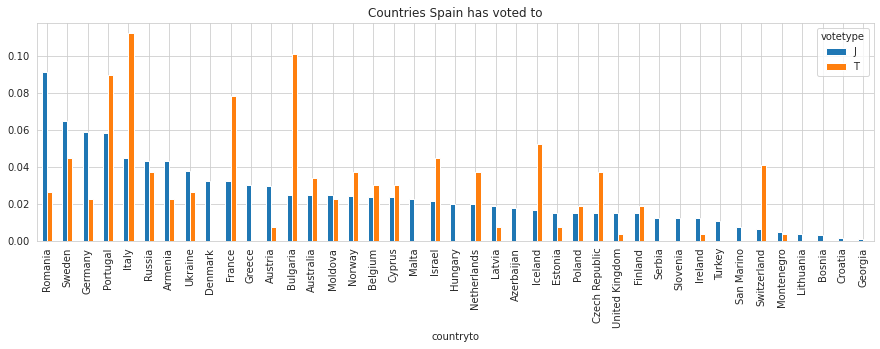

In [16]:
df2 \
    .query('year >= 2000 and countryfrom=="Spain"')\
    .pivot_table(index='countryto',columns='votetype', values='points',aggfunc='sum').fillna(0).sort_values('J',ascending=False)\
    .apply(lambda x: x/x.sum(), axis=0)\
    .plot(kind='bar',stacked=False,figsize=(15,4), title='Countries Spain has voted to');
plt.grid('off')
plt.show();

# First graph visualization

In [17]:
#use these function to filter out only the top N with most of point by countries
# or Top %percent of cumsum (useful for Pareto analysis).


def selectTopN(x,column, top=3):
    x = x.sort_values(column).tail(top)
    return x;

def selectTopPercent(x,column, percent=0.2, retrieve_first=True):
    x = x.sort_values(column, ascending=False)
    cut = x[column].cumsum() / x[column].sum();
    cut = cut <= percent;
    
    #return at least the first and avoid warnings
    if retrieve_first and cut.sum() ==0:
        return x.iloc[0];
    
    return x[cut==True];

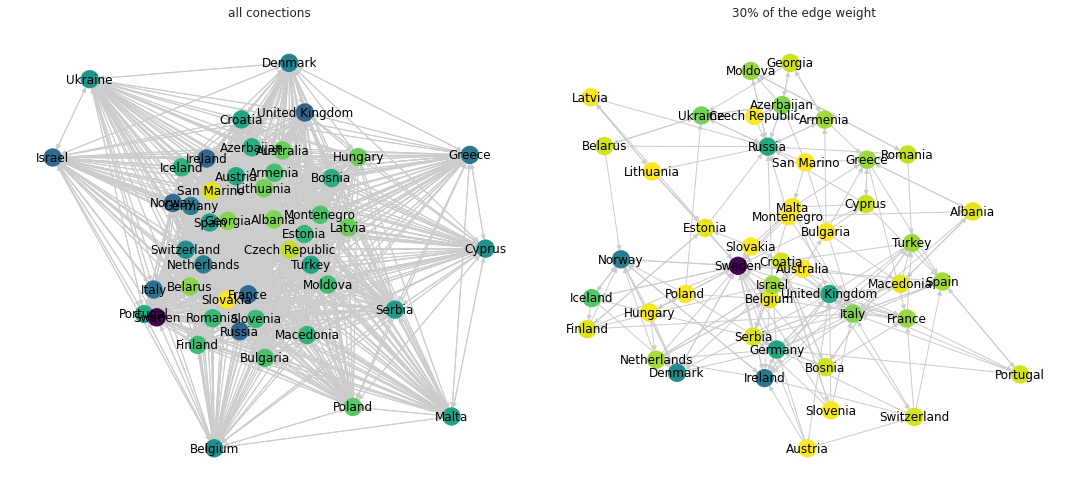

In [18]:
def plot(g, title, ax=None):
    if ax == None:
        ax = plt.gca();
        
    ax.set_title(title);
    
    np.random.seed(12)
    pos=nx.kamada_kawai_layout(g,weight='weight');
    nx.draw(g,
        pos = pos,
        ax=ax,
        cmap=plt.cm.viridis_r,
        edge_color='#cccccc',
        node_color=list(nx.pagerank(g).values()),
        font_color='#000',
        with_labels=True,
    )


plt.figure(figsize=(15,7));

###########################################################################
### chart with all connections
plt.subplot(121);
temp = df2.groupby(['countryfrom','countryto']).agg({'points':'sum'})\
    .reset_index().rename(columns={'points':'weight'})

g = nx.from_pandas_edgelist(temp,'countryfrom','countryto',['weight'], create_using=nx.OrderedDiGraph)
plot(g,title='all conections',ax=plt.gca())

###########################################################################
### chat with only top connections  limited to XX % total weight
plt.subplot(122);
temp = df2.groupby(['countryfrom','countryto']).agg({'points':'sum'})\
    .reset_index().rename(columns={'points':'weight'})\
    .groupby(['countryfrom']).apply(selectTopPercent,'weight',0.3).reset_index(drop=True)

g = nx.from_pandas_edgelist(temp,'countryfrom','countryto',['weight'], create_using=nx.OrderedDiGraph)
plot(g,title='30% of the edge weight',ax=plt.gca())


plt.tight_layout();

---
# 5. Exploring the network structure with triads analysis <a name="triads"></a>



Triad/Triangle represents the smalest communitiy possible in a network. Many configurations of triads are feasible in a directed graph. The picture below shows these combinations and how the choice of the TopN votes for each country could affect the network,  from sparse to a dense small world graph.

We can see that if we use all the edges the graph will be totally connected and no extra information can be found.

**So it is recommended to choose a cut off to select the most strong connections first**

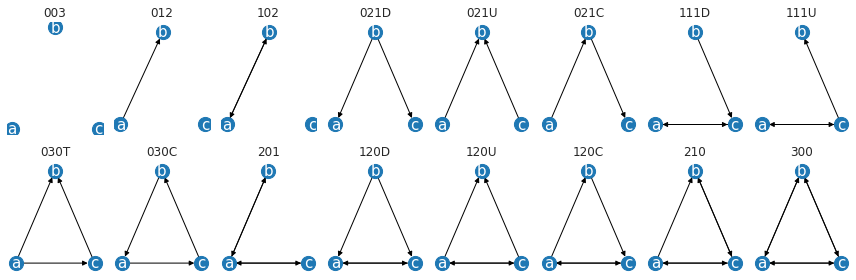

In [19]:
nColumns=8;
fig, axs = plt.subplots(int(np.ceil(len(nx.algorithms.triads.TRIAD_NAMES)/nColumns)), nColumns, figsize=(12,4))

for i,k in enumerate(list(nx.algorithms.triads.TRIAD_NAMES)):
    ax = axs[i//nColumns, i%nColumns]
    ax.set_title(f'{k}');
    nx.draw(nx.triad_graph(k), pos={'a':[0,0],'c':[10,0],'b':[5,10*np.sqrt(3)/2]},
            node_size=200, font_size=15,font_color='white', with_labels=True,ax=ax);

ax.set_facecolor('#cccccc');
plt.tight_layout();

In [20]:
def createTriac(df,topN, funcTop=selectTopN):
    temp = df.groupby(['countryfrom','countryto']).agg({'points':'sum'})\
    .reset_index().rename(columns={'points':'weight'})\
    .groupby(['countryfrom']).apply(funcTop,'weight',topN).reset_index(drop=True)

    g = nx.from_pandas_edgelist(temp,'countryfrom','countryto',['weight'], create_using=nx.OrderedDiGraph)
    return nx.triadic_census(g);

In [21]:
#selecting only relevant votes from most points to less point as connections
display(HTML("How chosing top N most voted countries as edges can affect the network"));
triads = pd.DataFrame([
    {'triad':c[0], 'count':c[1], 'topn':n}
    for n in [1,2,3,4,5,7,10,15,20,25,30,35,41,45]
    for c in createTriac(df2, n).items()
]).pivot_table(index='triad',columns='topn', values='count')
triads.reindex(index=list(nx.algorithms.triads.TRIAD_NAMES)).style.background_gradient()

HTML(value='How chosing top N most voted countries as edges can affect the network')

In [22]:
display(HTML("How chosing top N percent of votes countries as edges can affect the network"))
triads = pd.DataFrame([
    {'triad':c[0], 'count':c[1], 'percent':int(n*100)}
    for n in np.linspace(0,1,21)
    for c in createTriac(df2, n, selectTopPercent).items()
]).pivot_table(index='triad',columns='percent', values='count')
triads.reindex(index=list(nx.algorithms.triads.TRIAD_NAMES)).style.background_gradient()

HTML(value='How chosing top N percent of votes countries as edges can affect the network')

# 6. Exploring spectral graph properties <a name='spectral'></a>

- spectral graph theory help us:
 - To find best cuts
 - to uncover possible orders for hidden clustering ( see spectral clustering on Sklearn)

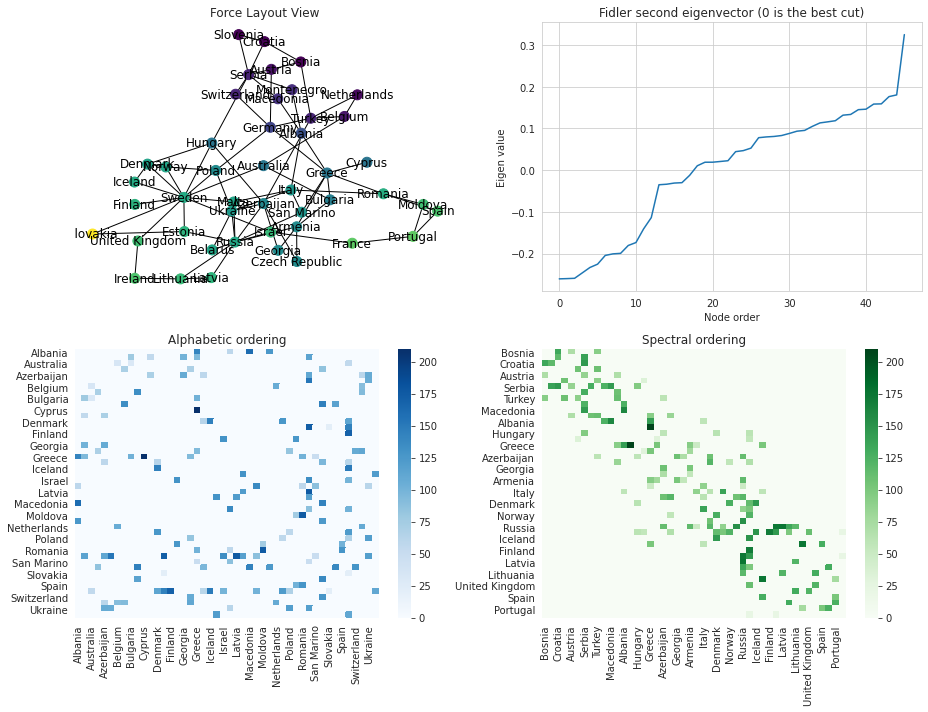

In [23]:
temp = df2.query('year >= 2000').groupby(['countryfrom','countryto']).agg({'points':'sum'})\
    .reset_index().rename(columns={'points':'weight'})\
    .groupby(['countryfrom']).apply(selectTopPercent,'weight',0.20).reset_index(drop=True)

g = nx.from_pandas_edgelist(temp,'countryfrom','countryto',['weight'])
#fidler is the second small eigenvector of the laplacian matrix ( Degree matrix - Adjacency matrix)
#The tells how connected is the graph.the graph can be cut, or split, in two groups with nodes with negative sign and positive sign
fidVect = nx.linalg.fiedler_vector(nx.Graph(g), weight='weight')



temp = nx.to_pandas_adjacency(g,weight='weight');
plt.subplots(figsize=(13, 10));
plt.subplot(221)
np.random.seed(24);
nx.draw_spring(g,weight=None, with_labels=True, node_color=fidVect, seed=42,node_size=100, iterations=50,k=1, scale=1, cmap=plt.cm.viridis)
plt.title('Force Layout View')
plt.subplot(222)
plt.title('Fidler second eigenvector (0 is the best cut)')
plt.plot(fidVect[np.argsort(fidVect)]);
plt.xlabel('Node order');
plt.ylabel('Eigen value')

plt.subplot(223)
sns.heatmap(temp.iloc[np.argsort(temp.index),np.argsort(temp.index)],cmap='Blues');
plt.title('Alphabetic ordering')
plt.subplot(224)
sns.heatmap(temp.iloc[np.argsort(fidVect),np.argsort(fidVect)],cmap='Greens');
plt.title('Spectral ordering')
plt.tight_layout()


# 7. Main Eurovision graph constrution <a name='MainGraph'></a>

Building a graph after considering data exploration

### Some assumptions:
- We are considering only editions after the 2000 year because:
 - Technology has changed the way these festival are broadcasted
 - Some countries have faced ruptures (Yuguslavia, Germany, etc)
 - Summing 2 decades will smooth the chance of a random country catch the attention of everyone, hence shine the light over partnership between countries (or juries teams).
- The graph we are exploring is a small world graph:
 - Many countries have high probability to be conected all other nodes.
 - The difference between the first, second and second partner, measured by the rank, compared to the rest is evidente. Removing lower votes helps us to uncover the relationship.
- Only the finals matter
- the number of points will be used as weight

In [24]:
def normalizer(x):
    x['points'] = x['points']/x['points'].sum()
    return x;

df3 = df2 \
    .query('final=="f" and year >= 2000 ')\
    .groupby(['countryfrom','countryto'])\
    .agg({'points':'sum'}).reset_index()\
    .groupby('countryfrom').apply(normalizer).reset_index(drop=True)\
    .groupby('countryfrom').apply(selectTopPercent,'points',0.30).reset_index(drop=True)\
    .rename(columns={'points':'weight'})

G = nx.from_pandas_edgelist(df3, 'countryfrom','countryto', ['weight'], create_using=nx.OrderedDiGraph)

In [25]:
pd.DataFrame(dict(G.out_degree()).items(),columns=['country','out_degree']).groupby('out_degree').count()

country
out_degree         
2                 5
3                19
4                17
5                 5

### Centrality measures

Informal definitions:

| Measure     | Concept                                                                                            |
|-------------|----------------------------------------------------------------------------------------------------|
| eigenvector | You are a friend of important people.                                                              |
| PageRank    | Important people points to you, you must be important. (eigenvector centrality for directed graph) |
| Degree      | if you have many connections you must be important.                                                |
| Closeness   | you can reach everyone easily.                                                                     |
| Betweeness  | you are the crossroad. Everyone has to pass through you to reach other parts of the graph.         |

Many other definitions and concepts are available, but most graph algoritms doesn't scale well (see cliques).

In [26]:
import functools
nodeMeasures = {
    'pagerank':nx.pagerank(G,weight='weight', max_iter=1000),
    'eigevector':nx.algorithms.centrality.eigenvector_centrality(G,max_iter=1000),
    'degree':nx.algorithms.centrality.degree_centrality(G),
    'betweenness':nx.algorithms.centrality.betweenness_centrality(G),
    'closeness':nx.algorithms.centrality.closeness_centrality(G),
};

nodeMeasures = [pd.DataFrame(nodeMeasures[v].items(), columns=['country',v]) for v in nodeMeasures]

nodeMeasures = functools.reduce(lambda  left,right: pd.merge(left,right,on='country', how='outer'), nodeMeasures)

def pond(x):
    x['pond'] = (1+x[['pagerank','degree','closeness','betweenness']]).cumprod()[-1]-1;
    return x;

nodeMeasures = nodeMeasures.apply(pond,axis=1)

nodeMeasures.corr().style.background_gradient().format("{:.1%}")

The centrality measures tend to be correlated but the topN changes a little. 

In [27]:
nodeMeasures\
    .sort_values('pond',ascending=False).set_index('country').round(2)\
    .style.background_gradient(axis=0).format("{:.5}")

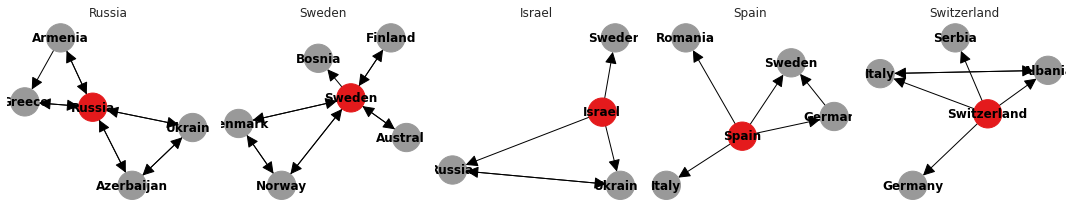

In [28]:
def draw_ego(G, n):
    np.random.seed(12);
    G = nx.ego_graph(G,n, radius=1);
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G,pos = pos,
                   with_labels=True,arrowsize=25, font_color='black', font_weight='bold', node_size=800,
                   node_color=[2 if nn == n else 1 for nn in G],
                   cmap=plt.cm.Set1_r);

plt.figure(figsize=(15,3))
cs = ['Russia','Sweden', 'Israel','Spain','Switzerland',];
for i, c in enumerate(cs):
    plt.subplot(101+len(cs)*10+i)
    draw_ego(G,c)
    plt.gca().set_title(c)
    
plt.tight_layout()
plt.grid(False);

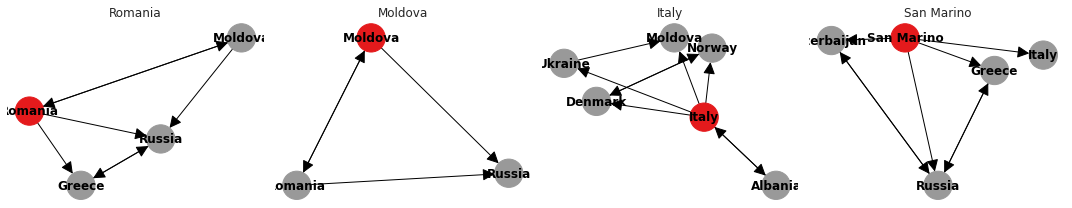

In [29]:
plt.figure(figsize=(15,3))
# pick your country here
cs = ['Romania','Moldova', 'Italy','San Marino',];
for i, c in enumerate(cs):
    plt.subplot(101+len(cs)*10+i)
    draw_ego(G,c)
    plt.gca().set_title(c)
    
plt.tight_layout()
plt.grid(False);

In [30]:
# we will pick pageRank becase it scale well and works with directed weighted graphs.

influence = nx.pagerank(G,weight='weight')
influenceMax = max(influence.values())

### Community detection

- Label Propagation:
 * Set random labels to the nodes; Choose the most common label in the neighbourhood;
 * This method tends to cluster nodes into large communites 
 * Very fast
 * Not a good option for highly dense graph.


- Louvain Modularity:
 * Brute force assign nodes to clusters in order to maximize the number of edges within cluster.
 * Produces good clusters.


- Spectral:
 * Kmeans of the spectral embedding (eigen (vectors+values) of the laplacian matrix)
 * Related to graph cuts

In [31]:
colors = [sns.color_palette()[c] for c in range(10)]
colors = ['#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255)) for (r, g, b) in colors ]


comType = 'louvain';
if comType == 'LPA':
    communities = {
        n:colors[i]
        for i, c in enumerate(nx.algorithms.community.label_propagation_communities(nx.Graph(G)))
        for n in list(c)
    };
elif comType == 'louvain':      
    communities = {c:colors[i] for c, i in louvain.best_partition(nx.Graph(G),random_state=42).items()}
elif comType == 'spectral':
    from sklearn.cluster import SpectralClustering
    sc = SpectralClustering(10, affinity='precomputed', n_init=100).fit(nx.to_numpy_matrix(nx.Graph(G)))
    communities = {c:colors[i] for c, i in zip(G.nodes(), sc.labels_)}

In [32]:
# changing the networkx function to draw labels with the same color as the nodes
def draw_networkx_labels(G, pos,
                         labels=None,
                         font_size=12,
                         font_color='k',
                         font_family='sans-serif',
                         font_weight='normal',
                         alpha=1.0,
                         bbox=None,
                         pos_shift = 0,
                         ax=None,
                         **kwds):
    """Draw node labels on the graph G.

    Parameters
    ----------
    G : graph
       A networkx graph

    pos : dictionary
       A dictionary with nodes as keys and positions as values.
       Positions should be sequences of length 2.

    labels : dictionary, optional (default=None)
       Node labels in a dictionary keyed by node of text labels

    font_size : int
       Font size for text labels (default=12)

    font_color : string
       Font color string (default='k' black)

    font_family : string
       Font family (default='sans-serif')

    font_weight : string
       Font weight (default='normal')

    alpha : float
       The text transparency (default=1.0)

    ax : Matplotlib Axes object, optional
       Draw the graph in the specified Matplotlib axes.

    Returns
    -------
    dict
        `dict` of labels keyed on the nodes

    Examples
    --------
    >>> G=nx.dodecahedral_graph()
    >>> labels=nx.draw_networkx_labels(G,pos=nx.spring_layout(G))

    Also see the NetworkX drawing examples at
    http://networkx.github.io/documentation/latest/gallery.html


    See Also
    --------
    draw()
    draw_networkx()
    draw_networkx_nodes()
    draw_networkx_edges()
    draw_networkx_edge_labels()
    """
    try:
        import matplotlib.pyplot as plt
        import matplotlib.cbook as cb
    except ImportError:
        raise ImportError("Matplotlib required for draw()")
    except RuntimeError:
        print("Matplotlib unable to open display")
        raise

    if ax is None:
        ax = plt.gca()

    if labels is None:
        labels = dict((n, n) for n in G.nodes())

    # set optional alignment
    horizontalalignment = kwds.get('horizontalalignment', 'center')
    verticalalignment = kwds.get('verticalalignment', 'center')
    
    if type(font_color) == str:
        font_color = [font_color]*len(labels);

    text_items = {}  # there is no text collection so we'll fake one
    for (n, label),_font_color in zip(labels.items(),font_color):
        (x, y) = pos[n]
        label = str(label)  # this will cause "1" and 1 to be labeled the same
        t = ax.text(x+pos_shift, y+pos_shift,
                  label,
                  size=font_size,
                  color=_font_color,
                  family=font_family,
                  weight=font_weight,
                  horizontalalignment=horizontalalignment,
                  verticalalignment=verticalalignment,
                  transform=ax.transData,
                  bbox=bbox,
                  clip_on=True,
                  )
        text_items[n] = t

    return text_items


In [33]:
def plotESC(G, communities, influence, pos,pos_shift=0):
    eColor = [communities[u] for (u, v, d) in G.edges(data=True)]
    
    nx.draw_networkx_edges(
        G, pos, 
        width=[10*d['weight']+1 for (u, v, d) in G.edges(data=True)],
        alpha=0.2,
        edge_color=eColor,
        zorder=25,);
    
    # nodes
    nx.draw_networkx_nodes(
        G,
        pos,
        linewidths=3,
        nodelist=influence.keys(),
        node_size=[400*v/influenceMax+30 for v in influence.values()],
        node_color=[communities[c] for c in influence.keys()],
        zorder=30,
    )
    
    draw_networkx_labels(
        G,
        pos,
        pos_shift=pos_shift,
        font_size=10,
        font_weight='bold',
        font_family='sans-serif',
        font_color=[communities[c] for c in influence.keys()],
        zorder=30,
    )

# Visualization using geolocation

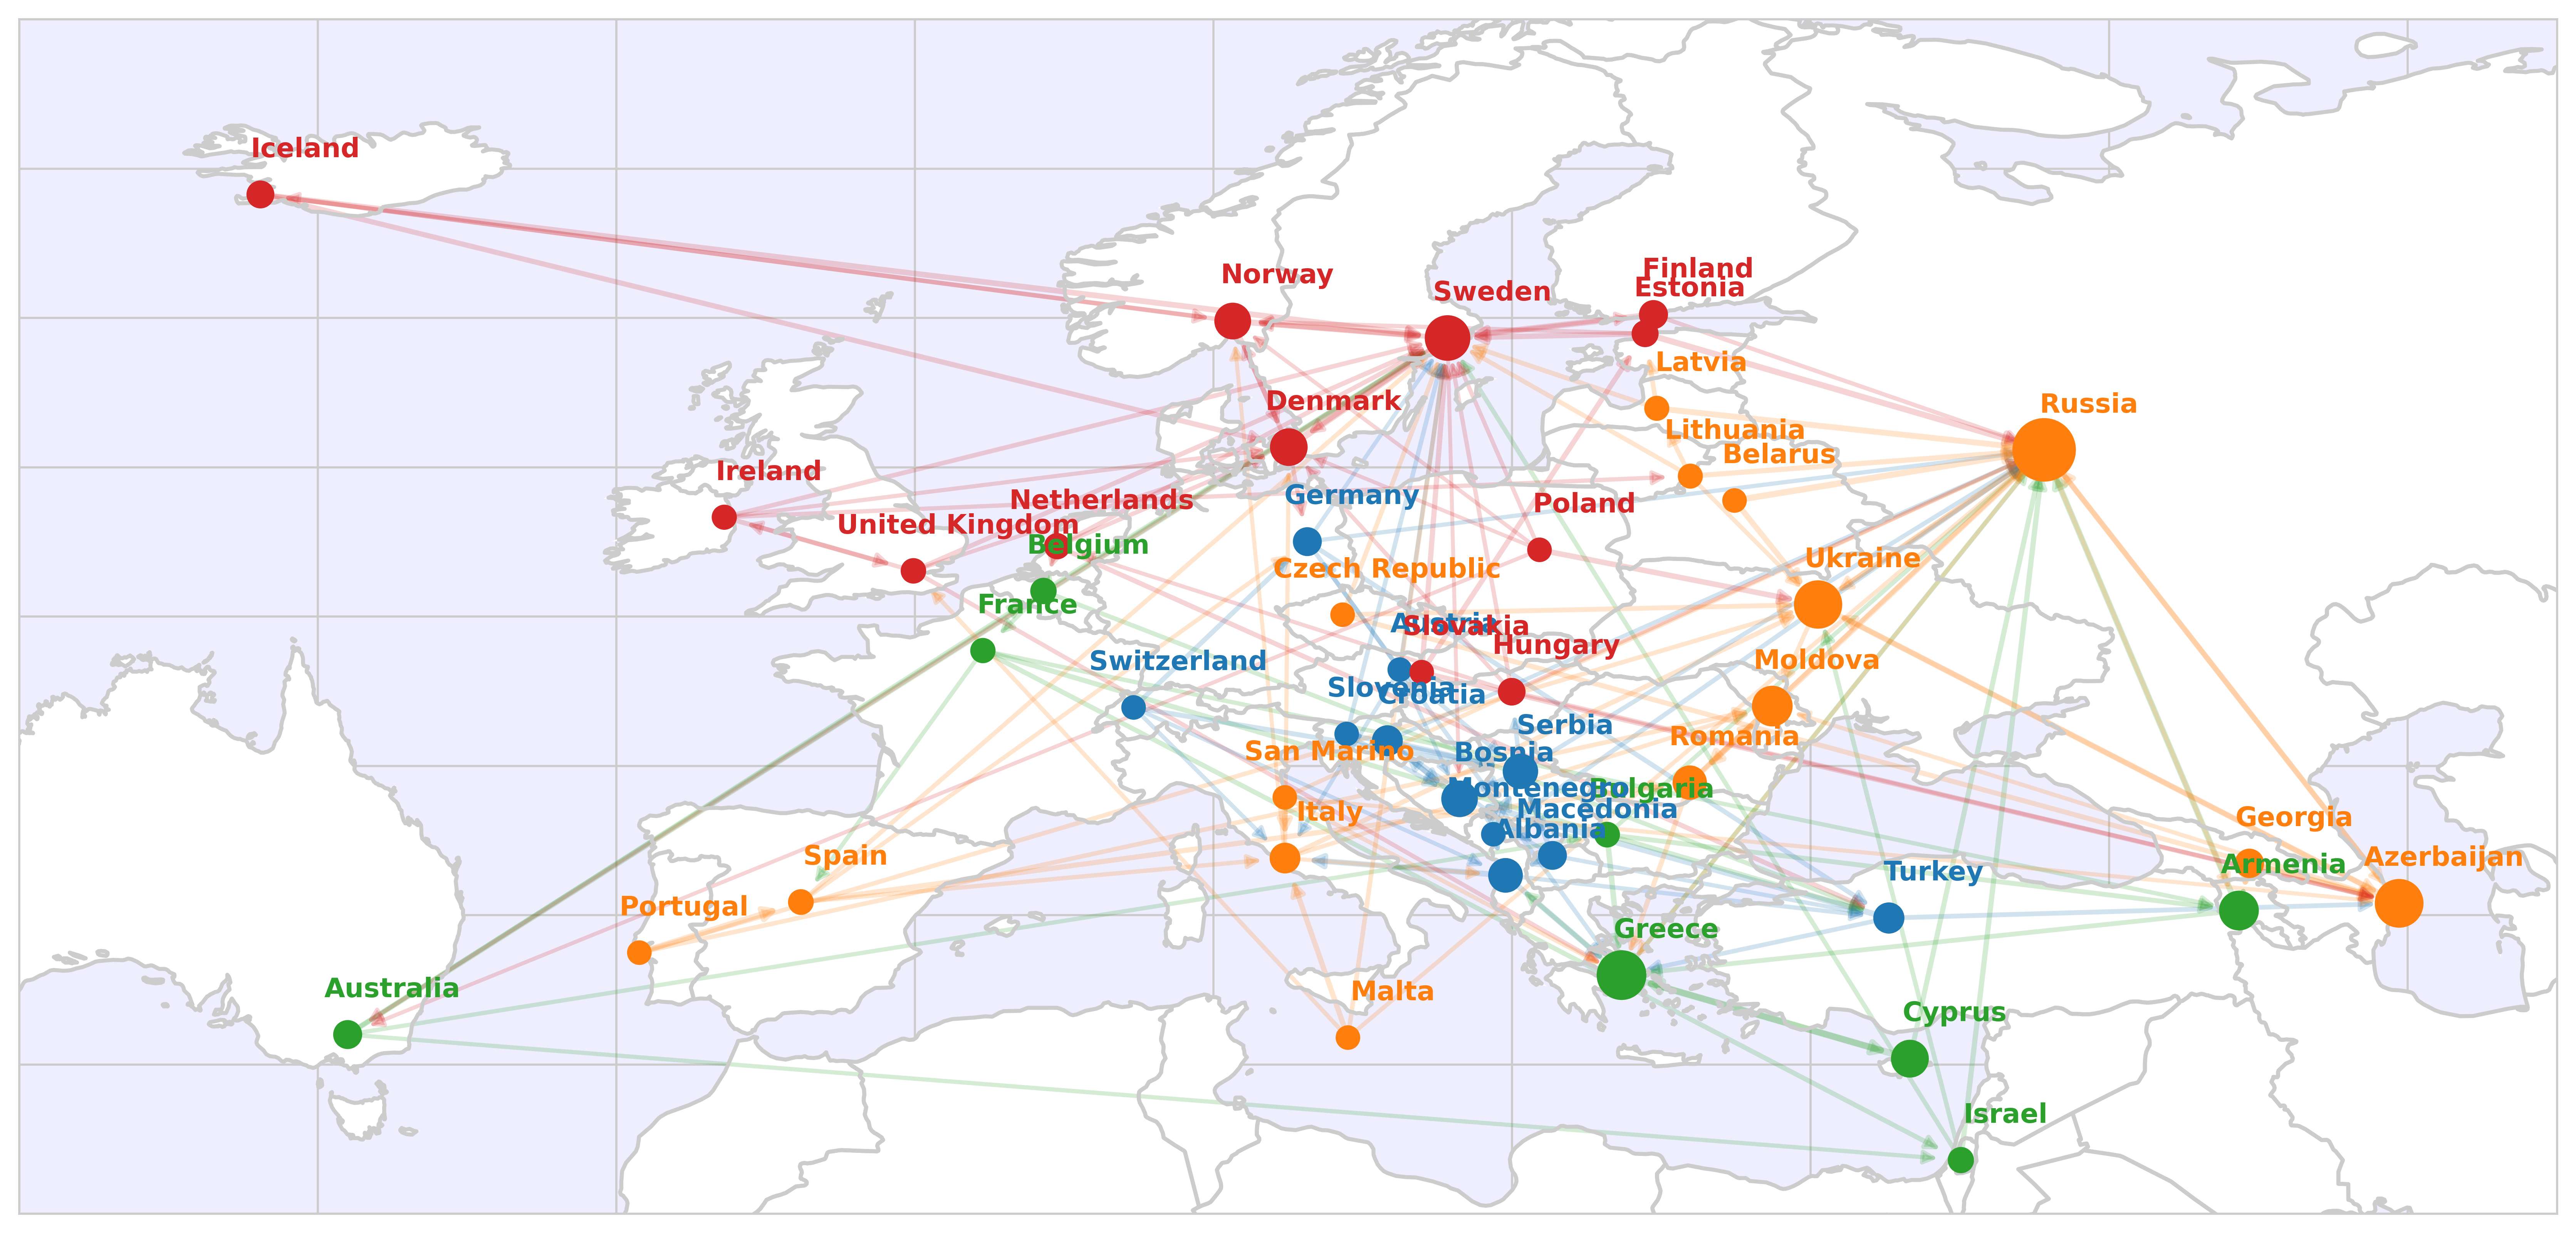

In [34]:
plt.figure(figsize=(17,15), dpi=500)
plt.gca().set_facecolor('#eeeeFF');
for d in countriesBorders['features']:
    if d['properties']['iso_a2'] in countriesCodes:
        plotCountry(d['geometry'],'a');
        
pos = {}
for c in G:
    pos[c] =  latLongFixed.query('countryfrom == "%s"'%c)[['Longitude','Latitude']].values.flatten()


plotESC(G, communities, influence, pos,pos_shift=1.5);


plt.axis('scaled')
#plt.grid(False)
plt.xlim(-30,55);
plt.ylim(30,70);

# Visualization using only the graph structure

In [35]:
shells = pd.merge(
    pd.DataFrame(communities.items(), columns=['country','cluster']),
    pd.DataFrame(dict(G.degree()).items(), columns=['country','degree'])
).sort_values(['cluster','degree'])['country'].values

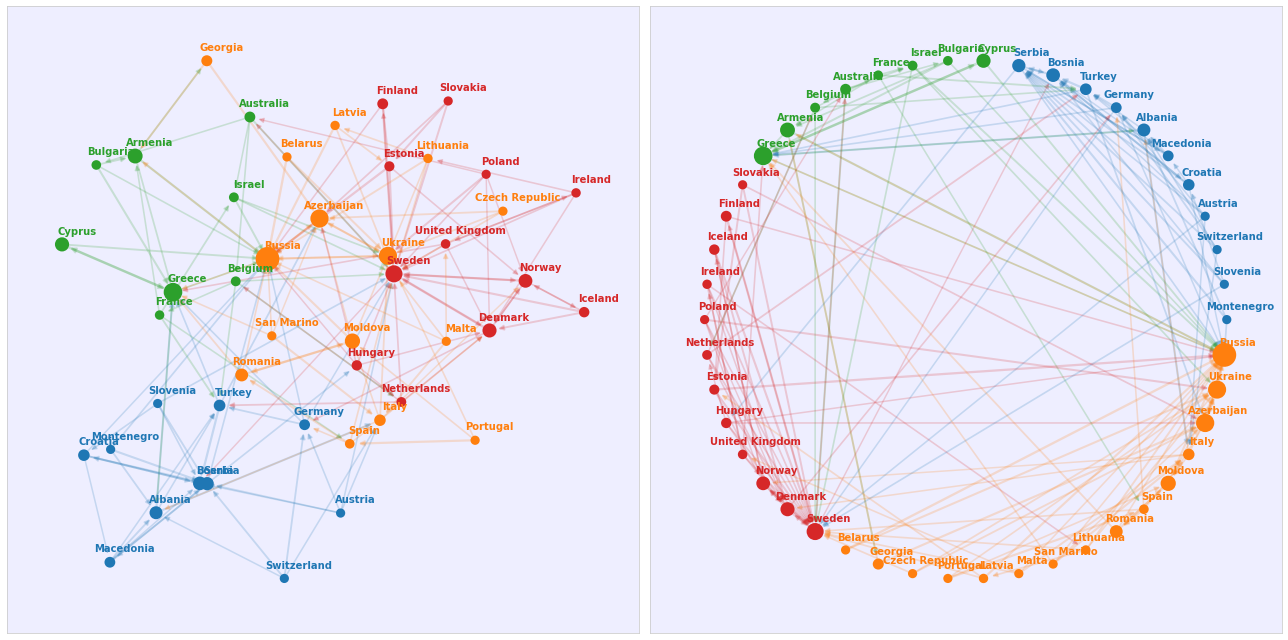

In [36]:
plt.figure(figsize=(18,9))

plt.subplot(121)
plt.gca().set_facecolor('#eeeeFF');
np.random.seed(42)
pos = nx.layout.fruchterman_reingold_layout(nx.Graph(G),k=0.01,iterations=100,scale = 2);
plotESC(G, communities, influence, pos,pos_shift=0.1);
plt.grid(False)

plt.subplot(122)
plt.gca().set_facecolor('#eeeeFF');
pos = nx.shell_layout(G,nlist=[shells])
plotESC(G, communities, influence, pos,pos_shift=0.05);
plt.grid(False)
plt.tight_layout()
plt.show()


# 8. Experimental part of the analysis <a name='experimental'/>

## Visualization using the embedding space

In [37]:
# function to generate random walk sequences of nodes
def get_randomwalk(G, node, path_length, seed=None):
    
    if seed is not None:
        rnd = random.Random(seed)
    else:
        rnd = random.Random()
        
    random_walk = [node]
    
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = rnd.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

* Tamanho do caminho (n_walks):
* Tamanho da exploração (walk_length): 
* Tamanho da janela do embedding (w2v_window)
* Tamanho da embedding (w2v_size):
* Número de época da rede neural (w2v_epochs)

In [38]:
def deepWalk(G,n_walks = 30, walk_length=15, w2v_window=5, w2v_size=100, w2v_epochs=50):
    all_nodes = list(G.nodes())
    random.seed(42)
    random_walks = []

    for n in tqdm(all_nodes):
        for i in range(n_walks):
            random_walks.append(get_randomwalk(G,n,walk_length,42))
    
    # train word2vec model
    model = Word2Vec(window = w2v_window,
                     size = w2v_size, #embedding size
                     sg = 1, # 0 cbow , 1 - skip-gram
                     hs = 0, # 0 - negative-sampling, 1-hierarquical softmax
                     negative = 10, # for negative sampling
                     alpha=0.001,
                     min_alpha=0.007,
                     seed = 14)

    model.build_vocab(random_walks, progress_per=2)
    model.train(random_walks, total_examples = model.corpus_count, epochs=w2v_epochs, report_delay=1)
    return model;

In [39]:
def deepwal_layout(G):
    from sklearn.manifold import TSNE
    nodes = G.nodes();
    np.random.seed(42);
    graphEmbeddings = deepWalk(G, w2v_size=5,w2v_window=3,walk_length=20,n_walks=20);
    vectors = graphEmbeddings[nodes];
    #print(vectors)
    loc = TSNE(2, random_state=42).fit_transform(vectors);
    
    return {n:v for n,v in zip(nodes,loc)}
    

100%|██████████| 46/46 [00:00<00:00, 1114.24it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


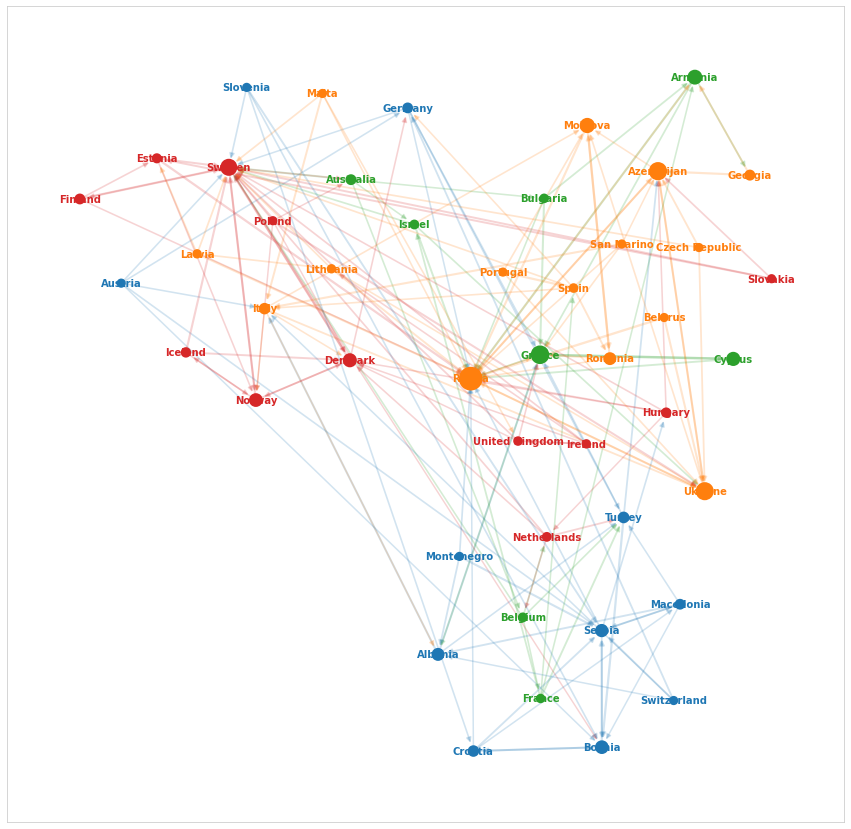

In [40]:
plt.figure(figsize=(15,15))

pos = deepwal_layout(G)

plotESC(G, communities, influence, pos,pos_shift=0);

#plt.axis('scaled')
plt.grid(False)
plt.show()


In [41]:
import math


# the Earth is a sphere so eclidean distance will not work
def haversine_distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

100%|██████████| 46/46 [00:00<00:00, 1093.68it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


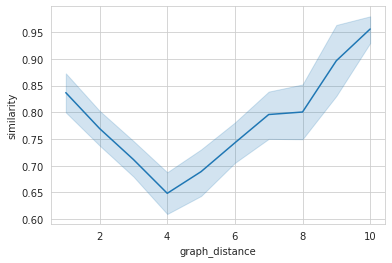

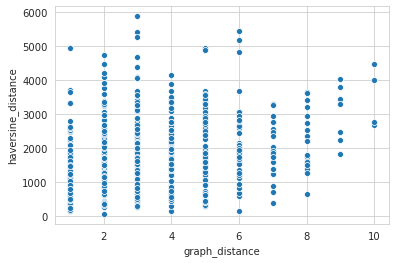

In [42]:
def a(G):
    nodes = G.nodes();
    graphEmbeddings = deepWalk(G, w2v_size=5,w2v_window=3,walk_length=15,n_walks=20);
    vectors = graphEmbeddings[nodes];
    
    
    latLongFixed2 = {c['countryfrom']:(c['Latitude'],c['Longitude']) for c in latLongFixed.to_dict('records')}
    
    
    #plot matriz de similaridade
    from sklearn.metrics import pairwise_distances
    from scipy.spatial.distance import cosine
    
    pairs = []

    for t in nx.all_pairs_dijkstra_path_length(G, weight=None):
        root = t[0];
        for k,v in t[1].items():
            if k > root:
                pairs.append({
                    'source':root,
                    'target':k,
                    'graph_distance':v,
                    'similarity':1-cosine(graphEmbeddings[root],graphEmbeddings[k]),
                    'haversine_distance':haversine_distance(latLongFixed2[root],latLongFixed2[k]),
                })
                

    sns.lineplot(x='graph_distance',y='similarity',data=pd.DataFrame(pairs));
    plt.show();
    

    sns.scatterplot(x='graph_distance',y='haversine_distance',data=pd.DataFrame(pairs))
a(G);